In [1]:
pip install gymnasium

In [2]:
pip install gymnasium[classic_control]

In [3]:
pip install imageio

In [4]:
import gymnasium as gym

env = gym.make("CartPole-v1", render_mode="rgb_array")
obs, info = env.reset()

done = False
while not done:
    frame = env.render()
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

In [5]:
%%writefile encoder.py
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_ch=1, code_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_ch, 16, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        self.fc_enc = None
        self.code_dim = code_dim

    def forward(self, x):
        B = x.shape[0]
        feat = self.conv(x)
        if self.fc_enc is None:
            flat_dim = feat.numel() // B
            self.fc_enc = nn.Linear(flat_dim, self.code_dim).to(x.device)
            print(f"✅ Initialized fc_enc with input size {flat_dim}")
        flat = feat.reshape(B, -1)
        z = self.fc_enc(flat)
        return z


Overwriting encoder.py


In [6]:
%%writefile decoder.py
import torch
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self, code_dim=128, n_prev=5, output_ch=1):
        super().__init__()
        self.n_prev = n_prev
        self.code_dim = code_dim
        total_dim = (n_prev + 1) * code_dim

        self.fc_dec = nn.Linear(total_dim, 64 * 8 * 8)

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, output_ch, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def decode(self, z, prev_latents=None):
        if prev_latents is not None:
            # prev_latents: (1, n_prev, code_dim)
            B = z.size(0)
            prev = prev_latents.view(B, self.n_prev * self.code_dim)
            z_cat = torch.cat([z, prev], dim=1)
        else:
            B = z.size(0)
            zeros = torch.zeros(B, self.n_prev * self.code_dim, device=z.device)
            z_cat = torch.cat([z, zeros], dim=1)

        feat = self.fc_dec(z_cat)
        feat = feat.view(-1, 64, 8, 8)
        rec = self.deconv(feat)
        return rec

    # Make forward = decode for convenience
    def forward(self, z, prev_latents=None):
        return self.decode(z, prev_latents)


Overwriting decoder.py


In [7]:
# ===============================
# Checking encoder.py and decoder.py
# ===============================
import torch
from encoder import Encoder
from decoder import Decoder

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(code_dim=128).to(DEVICE)
decoder = Decoder(code_dim=128, n_prev=5).to(DEVICE)

x = torch.rand(1, 1, 64, 64).to(DEVICE)
z = encoder(x)
rec = decoder(z)

print("Input:", x.shape)
print("Latent:", z.shape)
print("Reconstructed:", rec.shape)


✅ Initialized fc_enc with input size 4096
Input: torch.Size([1, 1, 64, 64])
Latent: torch.Size([1, 128])
Reconstructed: torch.Size([1, 1, 64, 64])


In [8]:
# >>> Cell 1: imports + hyperparams
import os
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import imageio
import matplotlib.pyplot as plt

# device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# hyperparams
CODE_DIM = 128
N_PREV = 5
IMG_H = IMG_W = 64
BATCH_SEQ = 1   # we process sequentially per frame; for AE training we'll use batch 1 per time-step
AE_EPOCHS = 12
TEACHER_FORCING_EPOCHS = 5    # use GT prev latents for these many epochs (teacher forcing)
SCHEDULED_SAMPLING_DECAY = 0.95  # multiply p_tf each epoch after TF phase
K_CHOICES = [128, 96, 64, 32]   # absolute K's
LAMBDA = 0.01  # penalty coefficient for K in reward (tune)
LEARNING_RATE = 1e-3

# file names (adjust to your paths)
FRAMES_NPY = "cartpole_frames.npy"  # if using cartpole frames saved earlier


Device: cpu


In [9]:
# >>> Cell 2: helper utilities (truncation, psnr)
import math

def apply_truncation(z, K):
    """
    z: (B, code_dim)
    K: int (<= code_dim)
    returns z_limited with zeros after index K
    """
    if K >= z.shape[1]:
        return z
    z_l = z.clone()
    z_l[:, K:] = 0.0
    return z_l

def psnr_from_mse(mse, max_val=1.0):
    # mse is scalar or numpy
    return 10.0 * math.log10(max_val * max_val / (mse + 1e-10))


In [10]:
# >>> Cell 3: import Encoder and Decoder
from encoder import Encoder
from decoder import Decoder

encoder = Encoder(input_ch=1, code_dim=CODE_DIM).to(DEVICE)
decoder = Decoder(output_ch=1, code_dim=CODE_DIM, n_prev=N_PREV).to(DEVICE)
print(encoder)
print(decoder)


Encoder(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
  )
)
Decoder(
  (fc_dec): Linear(in_features=768, out_features=4096, bias=True)
  (deconv): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)


In [11]:
# =========================================
# PERFECT CartPole recorder (works in Colab)
# Saves: cartpole_frames.npy  (shape = (T, 64, 64))
# =========================================
import numpy as np
import imageio
import cv2
import gymnasium as gym
import os

OUT_FILE = "cartpole_frames.npy"
T = 2000   # number of frames to record
RES = 64   # resize to 64x64

print("🎥 Recording stable CartPole dataset...")

env = gym.make("CartPole-v1", render_mode="rgb_array")
obs, info = env.reset()

frames = []
done = False
t = 0

while t < T:
    # --- get RGB frame
    frame = env.render()  # frame is correct numpy array in gymnasium
    frame = np.asarray(frame)

    # --- convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # --- resize to 64x64
    gray = cv2.resize(gray, (RES, RES), interpolation=cv2.INTER_AREA)

    frames.append(gray)

    # --- random action
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        obs, info = env.reset()

    t += 1

env.close()

frames = np.array(frames, dtype=np.uint8)           # (T, 64, 64)
frames = np.expand_dims(frames, -1)                 # (T, 64, 64, 1)

np.save(OUT_FILE, frames)

print(f"✅ Saved {OUT_FILE} | shape = {frames.shape}")


🎥 Recording stable CartPole dataset...
✅ Saved cartpole_frames.npy | shape = (2000, 64, 64, 1)


In [12]:
# >>> New Cell: Load new stable CartPole dataset
import numpy as np
import torch

DATASET_FILE = "cartpole_frames.npy"

frames = np.load(DATASET_FILE)        # shape (T, 64, 64, 1)
frames = frames.astype(np.float32) / 255.0
frames = np.transpose(frames, (0, 3, 1, 2))   # -> (T, 1, 64, 64)

T_total = frames.shape[0]

print("Loaded dataset:", frames.shape, "T_total =", T_total)


Loaded dataset: (2000, 1, 64, 64) T_total = 2000


In [13]:
# >>> Cell 6: AE training loop (sequential, with buffer and scheduled sampling)
from decoder import Decoder

optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=LEARNING_RATE)
criterion = nn.MSELoss()

p_tf = 1.0  # teacher forcing probability

for epoch in range(1, AE_EPOCHS + 1):
    total_loss = 0.0

    # scheduled sampling adjustment after TF epochs
    use_teacher = epoch <= TEACHER_FORCING_EPOCHS
    if not use_teacher:
        p_tf = max(0.0, p_tf * SCHEDULED_SAMPLING_DECAY)

    buffer = deque(maxlen=N_PREV)

    for t in range(T_total):

        # IMPORTANT CHANGE: using the new dataset shape
        x_t = torch.tensor(frames[t:t+1], dtype=torch.float32, device=DEVICE)  # (1,1,64,64)

        z_t = encoder(x_t)  # (1, code_dim)

        # warmup
        if len(buffer) < N_PREV:
            z_limited = z_t
            rec = decoder.decode(z_limited, prev_latents=None)
            loss = criterion(rec, x_t)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            buffer.append(z_limited.detach())
            continue

        # teacher vs closed-loop
        if use_teacher or (torch.rand(1).item() < p_tf):
            prev_stack = torch.cat(list(buffer), dim=0).unsqueeze(0)
            prev_stack = prev_stack.view(1, N_PREV, CODE_DIM)
        else:
            prev_stack = torch.cat(list(buffer), dim=0).unsqueeze(0)
            prev_stack = prev_stack.view(1, N_PREV, CODE_DIM)

        # scheduled K truncation
        if torch.rand(1).item() < 0.3:
            K = int(np.random.choice(K_CHOICES))
        else:
            K = CODE_DIM

        z_limited = apply_truncation(z_t, K)

        rec = decoder.decode(z_limited, prev_latents=prev_stack)

        loss = criterion(rec, x_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        buffer.append(z_limited.detach())

    avg_loss = total_loss / T_total
    print(f"AE Epoch {epoch}/{AE_EPOCHS} | avg loss: {avg_loss:.6f} | use_teacher={use_teacher} p_tf={p_tf:.3f}")

# save models
torch.save(encoder.state_dict(), "encoder.pth")
torch.save(decoder.state_dict(), "decoder.pth")
print("Saved encoder/decoder.")


✅ Initialized fc_enc with input size 4096
AE Epoch 1/12 | avg loss: 0.004040 | use_teacher=True p_tf=1.000
AE Epoch 2/12 | avg loss: 0.002542 | use_teacher=True p_tf=1.000
AE Epoch 3/12 | avg loss: 0.001236 | use_teacher=True p_tf=1.000
AE Epoch 4/12 | avg loss: 0.001154 | use_teacher=True p_tf=1.000
AE Epoch 5/12 | avg loss: 0.000978 | use_teacher=True p_tf=1.000
AE Epoch 6/12 | avg loss: 0.000878 | use_teacher=False p_tf=0.950
AE Epoch 7/12 | avg loss: 0.000411 | use_teacher=False p_tf=0.902
AE Epoch 8/12 | avg loss: 0.000337 | use_teacher=False p_tf=0.857
AE Epoch 9/12 | avg loss: 0.000270 | use_teacher=False p_tf=0.815
AE Epoch 10/12 | avg loss: 0.000280 | use_teacher=False p_tf=0.774
AE Epoch 11/12 | avg loss: 0.000250 | use_teacher=False p_tf=0.735
AE Epoch 12/12 | avg loss: 0.000262 | use_teacher=False p_tf=0.698
Saved encoder/decoder.


In [14]:
# >>> Cell 7: quick validation function - greedy K chosen externally or max K
def reconstruct_sequence_greedy(encoder, decoder, frames_np, K_choice=128, use_prev_recon=True):
    encoder.eval(); decoder.eval()
    T = frames_np.shape[0]
    recon_frames = []
    buffer = deque(maxlen=N_PREV)
    with torch.no_grad():
        for t in range(T):
            x = torch.tensor(frames_np[t:t+1], dtype=torch.float32, device=DEVICE)
            z = encoder(x)  # (1, code_dim)
            z_l = apply_truncation(z, K_choice)
            if len(buffer) < N_PREV:
                prev = None
            else:
                prev = torch.cat(list(buffer), dim=0).unsqueeze(0).view(1, N_PREV, CODE_DIM)
            rec = decoder.decode(z_l, prev_latents=prev)  # (1,1,H,W)
            recon_frames.append(rec.cpu().numpy()[0,0])  # (H,W)
            buffer.append(z_l)  # use z_l as prev latent (closed-loop)
    return np.stack(recon_frames, axis=0)

# example: reconstruct with K=128
recon = reconstruct_sequence_greedy(encoder, decoder, frames, K_choice=128)
print("recon shape", recon.shape)
# save a short preview as mp4 (normalize to 0..255)
sample_vid = (recon[:200] * 255).astype(np.uint8)
imageio.mimsave("recon_preview_k128.mp4", sample_vid, fps=30)
print("Saved recon_preview_k128.mp4")


recon shape (2000, 64, 64)
Saved recon_preview_k128.mp4


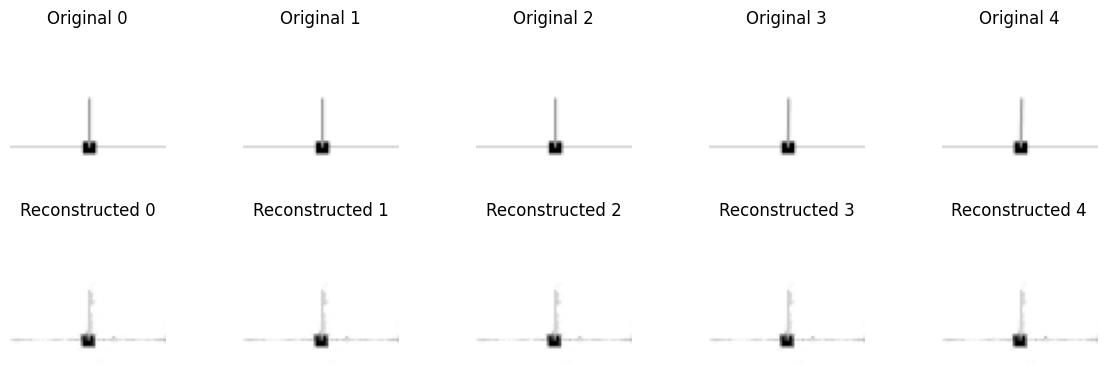

In [15]:
# >>> New Cell: visualize original vs reconstructed
import matplotlib.pyplot as plt

# покажем первые 5 кадров оригинальных и реконструированных
n_show = 5
fig, axes = plt.subplots(2, n_show, figsize=(12, 4))
for i in range(n_show):
    axes[0, i].imshow(frames[i, 0], cmap='gray')
    axes[0, i].set_title(f"Original {i}")
    axes[0, i].axis('off')
    axes[1, i].imshow(recon[i], cmap='gray')
    axes[1, i].set_title(f"Reconstructed {i}")
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()


✅ Saved comparison.gif (original vs reconstructed)


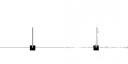

In [16]:
# >>> New Cell: make GIF comparison of original vs reconstructed
import imageio
import numpy as np

n_frames = 10  # сколько кадров показать
frames_orig = (frames[:n_frames, 0] * 255).astype(np.uint8)
frames_rec = (recon[:n_frames] * 255).astype(np.uint8)

# Создадим side-by-side изображения
combined = []
for i in range(n_frames):
    top = frames_orig[i]
    bottom = frames_rec[i]
    concat = np.concatenate([top, bottom], axis=1)  # слева оригинал, справа реконструкция
    combined.append(concat)

# Сохраняем GIF
imageio.mimsave("comparison.gif", combined, fps=2)
print("✅ Saved comparison.gif (original vs reconstructed)")

from IPython.display import Image
Image(filename="comparison.gif")
